In [19]:
import rmgpy
import numpy as np
from rmgpy.molecule.molecule import *
from rmgpy.species import *
from rmgpy.chemkin import *
from rmgpy.data.rmg import RMGDatabase
from IPython.display import display
from rmgpy.data.thermo import ThermoLibrary
from rmgpy.rmg.react import react
from rmgpy.species import Species
from rmgpy.reaction import Reaction
from rmgpy.data.rmg import get_db
from rmgpy.molecule.group import Group
from rmgpy.kinetics.arrhenius import ArrheniusBM
import time
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [ ]:
from rmgpy import settings
settings

### Load the database

In [4]:
database = RMGDatabase()
database.load(
            path = settings['database.directory'],
            thermo_libraries = ['Klippenstein_Glarborg2016', 'BurkeH2O2', 'thermo_DFT_CCSDTF12_BAC', 
                               'DFT_QCI_thermo',
                           'primaryThermoLibrary', 'primaryNS', 'NitrogenCurran', 'NOx2018', 'FFCM1(-)',
'SulfurLibrary', 'SulfurGlarborgH2S','SABIC_aromatics'],
            transport_libraries = [],
            reaction_libraries = [],
            seed_mechanisms = [],#['BurkeH2O2inN2','ERC-FoundationFuelv0.9'],
            kinetics_families = 'all',
            kinetics_depositories = ['training'],
            #frequenciesLibraries = self.statmechLibraries,
            depository = False, # Don't bother loading the depository information, as we don't use it
        )


In [5]:
family = database.kinetics.families["Singlet_Carbene_Intra_Disproportionation"]

In [6]:
family.clean_tree()

In [26]:
start = time.time()
family.generate_tree(thermo_database=database.thermo,
                     nprocs=1,
                     new_fraction_threshold_to_reopt_node=0.25,
                     max_batch_size=800,
                     extension_iter_max=2,
                     extension_iter_item_cap=100)

end = time.time()
print(f"Execution time: {end-start:.4f} s")
print(f"{len(family.groups.entries)} entries in the group")
print(family.groups.entries)

ERROR:root:4.0


Execution time: 0.0503 s
7 entries in the group
{'CH_C_unsaturated': <Entry index=-1 label="CH_C_unsaturated">, 'Root': <Entry index=0 label="Root">, 'Root_Ext-3C-R_Ext-4R!H-R_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_Sp-5R!H-4R!H': <Entry index=1 label="Root_Ext-3C-R_Ext-4R!H-R_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_Sp-5R!H-4R!H">, 'Root_Ext-3C-R_Ext-4R!H-R_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_N-Sp-5R!H-4R!H': <Entry index=2 label="Root_Ext-3C-R_Ext-4R!H-R_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_N-Sp-5R!H-4R!H">, 'Root_Ext-3C-R_Ext-4R!H-R_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_N-Sp-5R!H-4R!H_Ext-5R!H-R_Ext-6R!H-R_Sp-6R!H-1C': <Entry index=3 label="Root_Ext-3C-R_Ext-4R!H-R_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_N-Sp-5R!H-4R!H_Ext-5R!H-R_Ext-6R!H-R_Sp-6R!H-1C">, 'Root_Ext-3C-R_Ext-4R!H-R_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_N-Sp-5R!H-4R!H_Ext-5R!H-R_Ext-6R!H-R_N-Sp-6R!H-1C': <Entry index=4 label="Root_Ext-3C-R_Ext-4R!H-R_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_N-Sp-5R!H-4R!H_Ext-5R!H-R_Ext-6R!H-R_N-Sp-6R!H-1C">, 'Root_Ext-3C-R_Ext-4R!

In [27]:
start = time.time()
family.check_tree()
end = time.time()
print(f"Execution time: {end-start:.4f} s")

Execution time: 0.0003 s


In [28]:
start = time.time()
family.regularize(thermo_database=database.thermo)
end = time.time()
print(f"Execution time: {end-start:.4f} s")

Execution time: 0.0534 s


In [32]:
start = time.time()
templateRxnMap = family.get_reaction_matches(thermo_database=database.thermo,remove_degeneracy=True,
                                             get_reverse=True,exact_matches_only=False,fix_labels=True)
end = time.time()
print(f"Execution time: {end-start:.4f} s")
print(f"Size of template reaction map: {len(templateRxnMap)}")

Execution time: 0.0693 s
Size of template reaction map: 7


In [14]:
family.clean_tree_rules()

In [33]:
start = time.time()
family.make_bm_rules_from_template_rxn_map(templateRxnMap)#,nprocs=6)
end = time.time()
print(f"Execution time: {end-start:.4f} s")

Execution time: 0.0251 s


In [34]:
start = time.time()
family.check_tree()
end = time.time()
print(f"Execution time: {end-start:.4f} s")

Execution time: 0.0002 s


In [45]:
start = time.time()
errors,uncertainties = family.cross_validate(folds=0, iters=0,random_state=5)
end = time.time()
print(f"Execution time: {end-start:.4f} s")
print(f"Error values: {[x for x in errors.values()]}")

Execution time: 0.0523 s
Error values: [2.162978074020428, -3.8862904712643944, -11.04158009056224, 5.299736192061523]


### Make plots and save

Text(0.5, 0, '$|Ln(k_{est}/k_{rxn})|$')

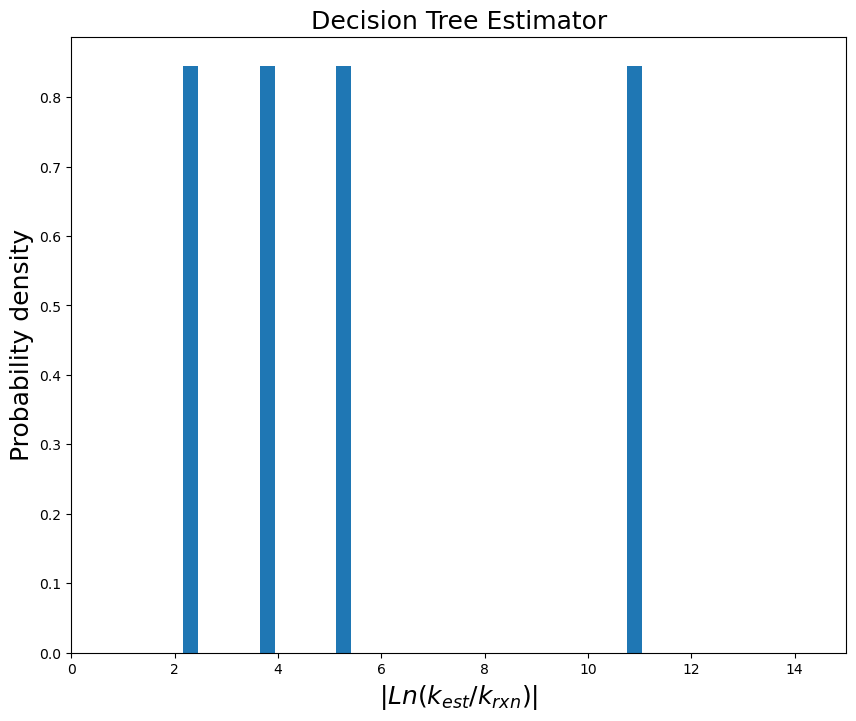

In [46]:
plt.figure(figsize=(10,8))
plt.hist(np.abs(list(errors.values())),bins=30, density=True)
plt.title('Decision Tree Estimator',fontsize=18)
#plt.ylim(0,.4)
plt.xlim(0,15)
plt.ylabel('Probability density',fontsize=18)
plt.xlabel(r'$|Ln(k_{est}/k_{rxn})|$',fontsize=18)

In [47]:
save_path = os.path.join(settings['database.directory'], 'kinetics', 'families', family.name)
print(save_path)

/home/jonzheng/greengroup/RMG/RMG-database/input/kinetics/families/Singlet_Carbene_Intra_Disproportionation


In [22]:
family.save(save_path)